In [1]:
import pandas as pd

data_engagement=pd.read_csv('takehome_user_engagement.csv', encoding='latin-1')
data_engagement.set_index(pd.DatetimeIndex(data_engagement['time_stamp']),inplace=True)
data_user=pd.read_csv('takehome_users.csv', encoding='latin-1')
data_engagement.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [2]:
data_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
print("The number of users who signed up for the application are", len(data_user['object_id'].unique()))
print("The number of users who ever loggin in to the application are", len(data_engagement['user_id'].unique()))
print("The number of users who signed up but never used the application are:", len(data_user['object_id'].unique())- len(data_engagement['user_id'].unique()))

The number of users who signed up for the application are 12000
The number of users who ever loggin in to the application are 8823
The number of users who signed up but never used the application are: 3177


This can also be proved by checking the number of users in the user_data dataframe whose last_session_creation_time is null.

In [4]:
print("The number of users who signed up but never used the application are:", len(data_user[data_user['last_session_creation_time'].isnull()]))

The number of users who signed up but never used the application are: 3177


So, at this point we have two data sets. The first, we can use to determine if a user is "adopted" the app. Then with the second data set we can use these determined ID's to then produce and evaluate a predictive model. As part of this process we will have to deal with any missing, duplicate, and/or irrelevant data points.
As outlined, in this case an adopted user is any ID that had logged in on at least 3 serarate occasions in a 7 day period.

In [5]:
#Resample the engagement data for 1 week and group by users and sums the number of visits per week
group = data_engagement.groupby('user_id').resample('1W').sum()


In [6]:
group = group[group['user_id'].isnull()==False].drop('user_id',axis=1)
group.head()

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0

In [7]:
logged_users = group['visited']>=1
import numpy as np
logged_users = logged_users.groupby(level=0).apply(np.sum)
logged_users = logged_users[logged_users!=0]
logged_users = pd.DataFrame(logged_users,index=logged_users.index)
logged_users.columns = ['Logged Weeks']
logged_user_visit = logged_users.merge(data_user,right_on='object_id',left_on='user_id',how='right')
logged_user_visit.info()
logged_user_visit.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
Logged Weeks                  8823 non-null float64
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.1+ MB


,Logged Weeks,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,11.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,1.0,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,1.0,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,1.0,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### Users

In [8]:
import numpy as np
#tags weeks that had less than 3 visits for all users#tags w 
active_users = group['visited']>=3
#Groups by users and sums up the number of weeks that had 3 or more visits
active_users = active_users.groupby(level=0).apply(np.sum)
#removes users with no weeks that had 3 or more visits
active_users_1 = active_users[active_users!=0]
active_users = active_users[active_users!=0]
active_users = pd.DataFrame(active_users,index=active_users.index)
active_users.columns = ['Active Weeks']
active_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1445 entries, 2 to 11988
Data columns (total 1 columns):
Active Weeks    1445 non-null int64
dtypes: int64(1)
memory usage: 22.6 KB


In [9]:
act_user_data = active_users.merge(logged_user_visit,left_index=True,right_on='object_id',how='right')
act_user_data.head()

,Active Weeks,Logged Weeks,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,NaN,1.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,1.0,11.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,NaN,1.0,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,NaN,1.0,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,NaN,1.0,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [10]:
act_user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
Active Weeks                  1445 non-null float64
Logged Weeks                  8823 non-null float64
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(4), int64(4), object(4)
memory usage: 1.2+ MB


Now that we have added two columns, active_weeks that is the users who have been active for 3 or more times in a week and logged weeks for users who have signed uo for the application and have logged in at least once, lets make the values boolean. i.e. 1 for any entry 0 for null.

In [11]:
act_user_data['Active Weeks']=act_user_data['Active Weeks'].apply(lambda x:1 if x>0 else 0)
act_user_data['Logged Weeks']=act_user_data['Logged Weeks'].apply(lambda x:1 if x>0 else 0)
act_user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
Active Weeks                  12000 non-null int64
Logged Weeks                  12000 non-null int64
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(6), object(4)
memory usage: 1.2+ MB


In [12]:
model_data = act_user_data.set_index('object_id').sort_index()



In [13]:
model_data['email'] = model_data['email'].apply(lambda x: x[x.find('@')+1:])
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
model_data['email'] = model_data['email'].apply(lambda x: 'other' if x not in major_domains else x[:x.find('.')])

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
print(model_data['email'].value_counts())
sns.countplot(model_data['email'],palette="Set3")
plt.show()

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64


<Figure size 640x480 with 1 Axes>

In [15]:
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].fillna(0)
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].apply(
        lambda x: 1 if x>0 else 0)


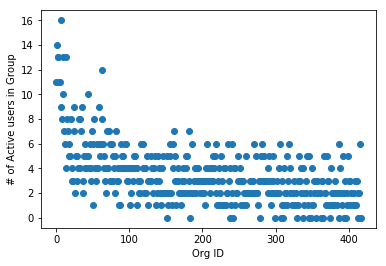

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
org = model_data.groupby('org_id').sum()
plt.scatter(org.index,org['Active Weeks'])
plt.ylabel('# of Active users in Group')
plt.xlabel('Org ID')
plt.show()

In [17]:
model_data.head()

,Active Weeks,Logged Weeks,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,,,
1,0,1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,1.398139e+09,1,0,11,1
2,1,1,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,1.396238e+09,0,0,1,1
3,0,1,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,1.363735e+09,0,0,94,1
4,0,1,2013-05-21 08:09:28,Clausen Nicklas,yahoo,GUEST_INVITE,1.369210e+09,0,0,1,1
5,0,1,2013-01-17 10:14:20,Raw Grace,yahoo,GUEST_INVITE,1.358850e+09,0,0,193,1


In [18]:
model_data['last_session_creation_time'] = model_data['last_session_creation_time'].fillna(model_data['last_session_creation_time'].median())


model_data['creation_time'] = pd.to_datetime(model_data['last_session_creation_time'])
model_data['creation_time'] = pd.to_datetime(model_data['creation_time'])
# day of the week account created
model_data['day_created'] = model_data['creation_time'].apply(lambda x: x.dayofweek)
# hour of the day account created
model_data['hour_created'] = model_data['creation_time'].apply(lambda x: x.hour)
# drop the original column
model_data.drop('creation_time', axis=1, inplace=True)

In [19]:
model_data.drop(['name','invited_by_user_id'],axis=1,inplace=True)
model_data = pd.get_dummies(data=model_data,columns=['creation_source','email'])
model_data.head()


,Active Weeks,Logged Weeks,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,day_created,hour_created,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_cuvox,email_gmail,email_gustr,email_hotmail,email_jourrapide,email_other,email_yahoo
object_id,,,,,,,,,,,,,,,,,,,,
1,0,1,1.398139e+09,1,0,11,3,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,1,1.396238e+09,0,0,1,3,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,1,1.363735e+09,0,0,94,3,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,1,1.369210e+09,0,0,1,3,0,1,0,0,0,0,0,0,0,0,0,0,1
5,0,1,1.358850e+09,0,0,193,3,0,1,0,0,0,0,0,0,0,0,0,0,1


In [20]:
model_data.info()
model_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 20 columns):
Active Weeks                          12000 non-null int64
Logged Weeks                          12000 non-null int64
last_session_creation_time            12000 non-null float64
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
day_created                           12000 non-null int64
hour_created                          12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
email_cuvox                           12000 non-null uint8
email_gmail                           12000 non-null uint8
emai

,Active Weeks,Logged Weeks,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,day_created,hour_created,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,email_cuvox,email_gmail,email_gustr,email_hotmail,email_jourrapide,email_other,email_yahoo
object_id,,,,,,,,,,,,,,,,,,,,
1,0,1,1.398139e+09,1,0,11,3,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1,1,1.396238e+09,0,0,1,3,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,1,1.363735e+09,0,0,94,3,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,1,1.369210e+09,0,0,1,3,0,1,0,0,0,0,0,0,0,0,0,0,1
5,0,1,1.358850e+09,0,0,193,3,0,1,0,0,0,0,0,0,0,0,0,0,1


In [21]:
list(model_data['Active Weeks'].value_counts().index)

[0, 1]

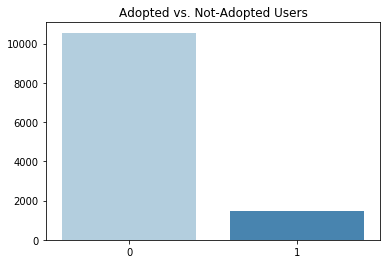

In [22]:
sns.barplot(x = [0,1], y = model_data['Active Weeks'].value_counts(), palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

As there is a heavy imbalance in the classes here I will split the data into training and testing data and then oversample the training the data to balance out the classes w/o distorting the testing data.

In [23]:
X = model_data.drop('Active Weeks', axis=1)
y = model_data['Active Weeks']

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, 
                                                           random_state=2007, stratify=model_data['Active Weeks'])

In [25]:

from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)
# X_resampled, y_resampled = X_train, y_train
#ADASYN().fit_sample(X, y)

X_resampled, y_resampled=X_train, y_train

### Predictive Models and Feature Importance

In [26]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
#from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [27]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [29]:
names = []
scores = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


  Name     Score
0  KNN  0.921111
1  SVC  0.879444
2   LR  0.879444
3   DT  0.895556
4  GNB  0.879444
5   RF  0.920556
6   GB  0.928056


In [31]:
names = []
scores = []
for name, model in models:
    
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/deepikasridhar/anacon

  Name     Score
0  KNN  0.922083
1  SVC  0.879583
2   LR  0.879583
3   DT  0.889917
4  GNB  0.879583
5   RF  0.922167
6   GB  0.928917


In [ ]:
# Visualize model model scores
axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val, palette='Blues')
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

Train and tune a single model.

In [32]:
clf = GradientBoostingClassifier(verbose=True)
clf.fit(X_train, y_train)
print('Train Score:', round(clf.score(X_train,y_train),3))
print('Test Score:', round(clf.score(X_test,y_test),3))

      Iter       Train Loss   Remaining Time 
         1           0.6362            0.84s
         2           0.5804            0.76s
         3           0.5406            0.70s
         4           0.5102            0.67s
         5           0.4858            0.65s
         6           0.4659            0.63s
         7           0.4494            0.62s
         8           0.4356            0.60s
         9           0.4243            0.59s
        10           0.4147            0.58s
        20           0.3668            0.50s
        30           0.3542            0.42s
        40           0.3450            0.36s
        50           0.3377            0.30s
        60           0.3307            0.24s
        70           0.3257            0.17s
        80           0.3214            0.12s
        90           0.3161            0.06s
       100           0.3110            0.00s
Train Score: 0.942
Test Score: 0.928


In [33]:
# TP / FP 
confusion_matrix(y_test, clf.predict(X_test))

array([[3066,  100],
       [ 159,  275]])

Examine the model feature importance.

In [34]:
clf.feature_importances_.shape

(19,)

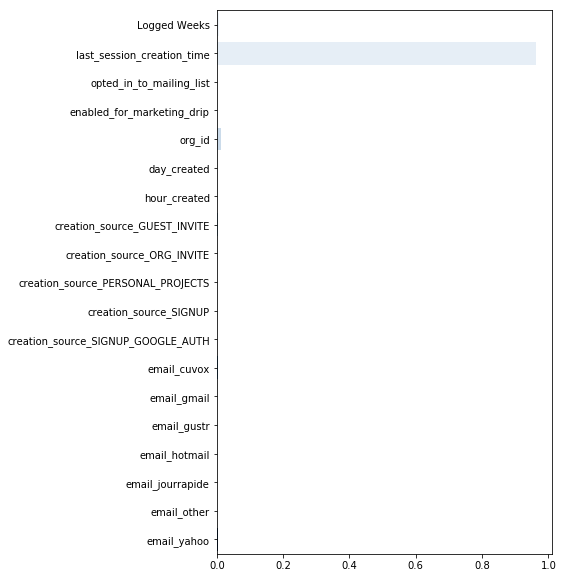

In [35]:
features = pd.Series(clf.feature_importances_, index=X.columns)
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=clf.feature_importances_, palette='Blues')

In [36]:
# Find feature importances
feature_importance = pd.DataFrame(clf.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
last_session_creation_time,0.961450
org_id,0.013565
Logged Weeks,0.006272
creation_source_GUEST_INVITE,0.004308
email_yahoo,0.004235
email_cuvox,0.002274
creation_source_SIGNUP,0.001926
enabled_for_marketing_drip,0.001575
creation_source_PERSONAL_PROJECTS,0.000999
creation_source_SIGNUP_GOOGLE_AUTH,0.000813


As can be seen above the most important feature is the most recent log-in time.

now lets try some hyperparameter tunning.

In [37]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                                min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=2007), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [39]:
 gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 50}, 0.932139474187451)

In [41]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=60, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=2007), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train,y_train)

gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_samples_split': 600}, 0.9329558190872227)

In [42]:
clf_tuned = GradientBoostingClassifier(learning_rate=0.05, 
                                       n_estimators=70, 
                                       max_features='auto', 
                                       subsample=0.85,
                                       max_depth= 6,
                                       min_samples_split= 800,
                                       random_state=2007,
                                       verbose=True)

In [43]:
clf_tuned.fit(X_train,y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6821           0.0496            0.91s
         2           0.6515           0.0344            0.84s
         3           0.6108           0.0279            0.81s
         4           0.5882           0.0252            0.79s
         5           0.5631           0.0199            0.78s
         6           0.5527           0.0181            0.77s
         7           0.5376           0.0167            0.75s
         8           0.5168           0.0147            0.75s
         9           0.5036           0.0135            0.76s
        10           0.4890           0.0125            0.74s
        20           0.4132           0.0044            0.57s
        30           0.3791           0.0021            0.44s
        40           0.3653           0.0008            0.32s
        50           0.3532           0.0005            0.21s
        60           0.3446           0.0002            0.11s
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=800,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              n_iter_no_change=None, presort='auto', random_state=2007,
              subsample=0.85, tol=0.0001, validation_fraction=0.1,
              verbose=True, warm_start=False)

In [44]:
print('Train Score:', round(clf_tuned.score(X_train,y_train),3))
print('Test Score:', round(clf_tuned.score(X_test,y_test),3))

Train Score: 0.936
Test Score: 0.928


With approximatly 81% of the userbase no considered non adoptive users, we have an obvious area for improvment in user engagment. This is also exemplified by the fact that we have several thousand users who, after creating an account, never engaged with the system (loged in). From the feature importances the last log in time was the most highly correlated with a positive prediction, which is not surprising. However, I am not certain how useful the is as a real world predictor as those who have logged in more recently are more likely to be in the engaged crowed, and thus this dilutes its usefulness as a predictor of whether or not a novel user will become an adopted user. My recommendations at this point would be to identify the top sources of engaged users (sign-up origin) and increase marketing efforts there. Further, we can conduct more detailed surveys amoungst adopted users to attempt to identify new commonfeatures to add to the model that may increase its validity.